In [78]:
import random

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

In [79]:
retrain = True
cache_path = "./models/"
model_name = "american_dataset.h5"
training_history = "training_history.csv"

if not os.path.isdir(cache_path):
    os.mkdir(cache_path)

if not os.path.exists(cache_path + model_name) or not os.path.exists(cache_path + training_history):
    retrain = True


plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [20, 15]

train_df = pd.read_csv("data/sign_mnist_train.csv")
test_df = pd.read_csv("data/sign_mnist_test.csv")
print(retrain)

True


In [80]:
classes = pd.unique(train_df.label)
print(len(classes))
classes= ["A","B","C","D","E","F","G","H","I","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"]
print(len(classes))
train_num_samples = len(train_df)
test_num_samples = len(test_df)
print(f'Training Samples: {train_num_samples}')
print(f'Training Samples: {test_num_samples}')
print(f'Classes: {classes}')



24
24
Training Samples: 27455
Training Samples: 7172
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [81]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [82]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(27455, 28, 28, 1)
(27455, 24)
(7172, 28, 28, 1)
(7172, 24)


In [83]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [84]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 14, 14, 50)      

In [85]:
if retrain:
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
    history = model.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])
    model.save(cache_path + model_name)
    history = pd.DataFrame(history.history)
    history.to_csv(cache_path + training_history)
else:
    model = load_model(cache_path + model_name)
    history = pd.read_csv(cache_path + training_history)

Epoch 1/20
215/215 [==============================] - 21s 91ms/step - loss: 1.0894 - accuracy: 0.6568 - val_loss: 3.2107 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 19s 89ms/step - loss: 0.2303 - accuracy: 0.9253 - val_loss: 1.2712 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 19s 89ms/step - loss: 0.1102 - accuracy: 0.9645 - val_loss: 0.2441 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 19s 89ms/step - loss: 0.0662 - accuracy: 0.9792 - val_loss: 0.0528 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 19s 89ms/step - loss: 0.0504 - accuracy: 0.9840 - val_loss: 0.1462 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 19s 89ms/step - loss: 0.0319 - accuracy: 0.9900 - val_loss: 0.0292 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 19s 

Text(0.5, 1.0, 'Zeitliche Entwicklung der Accuracy')

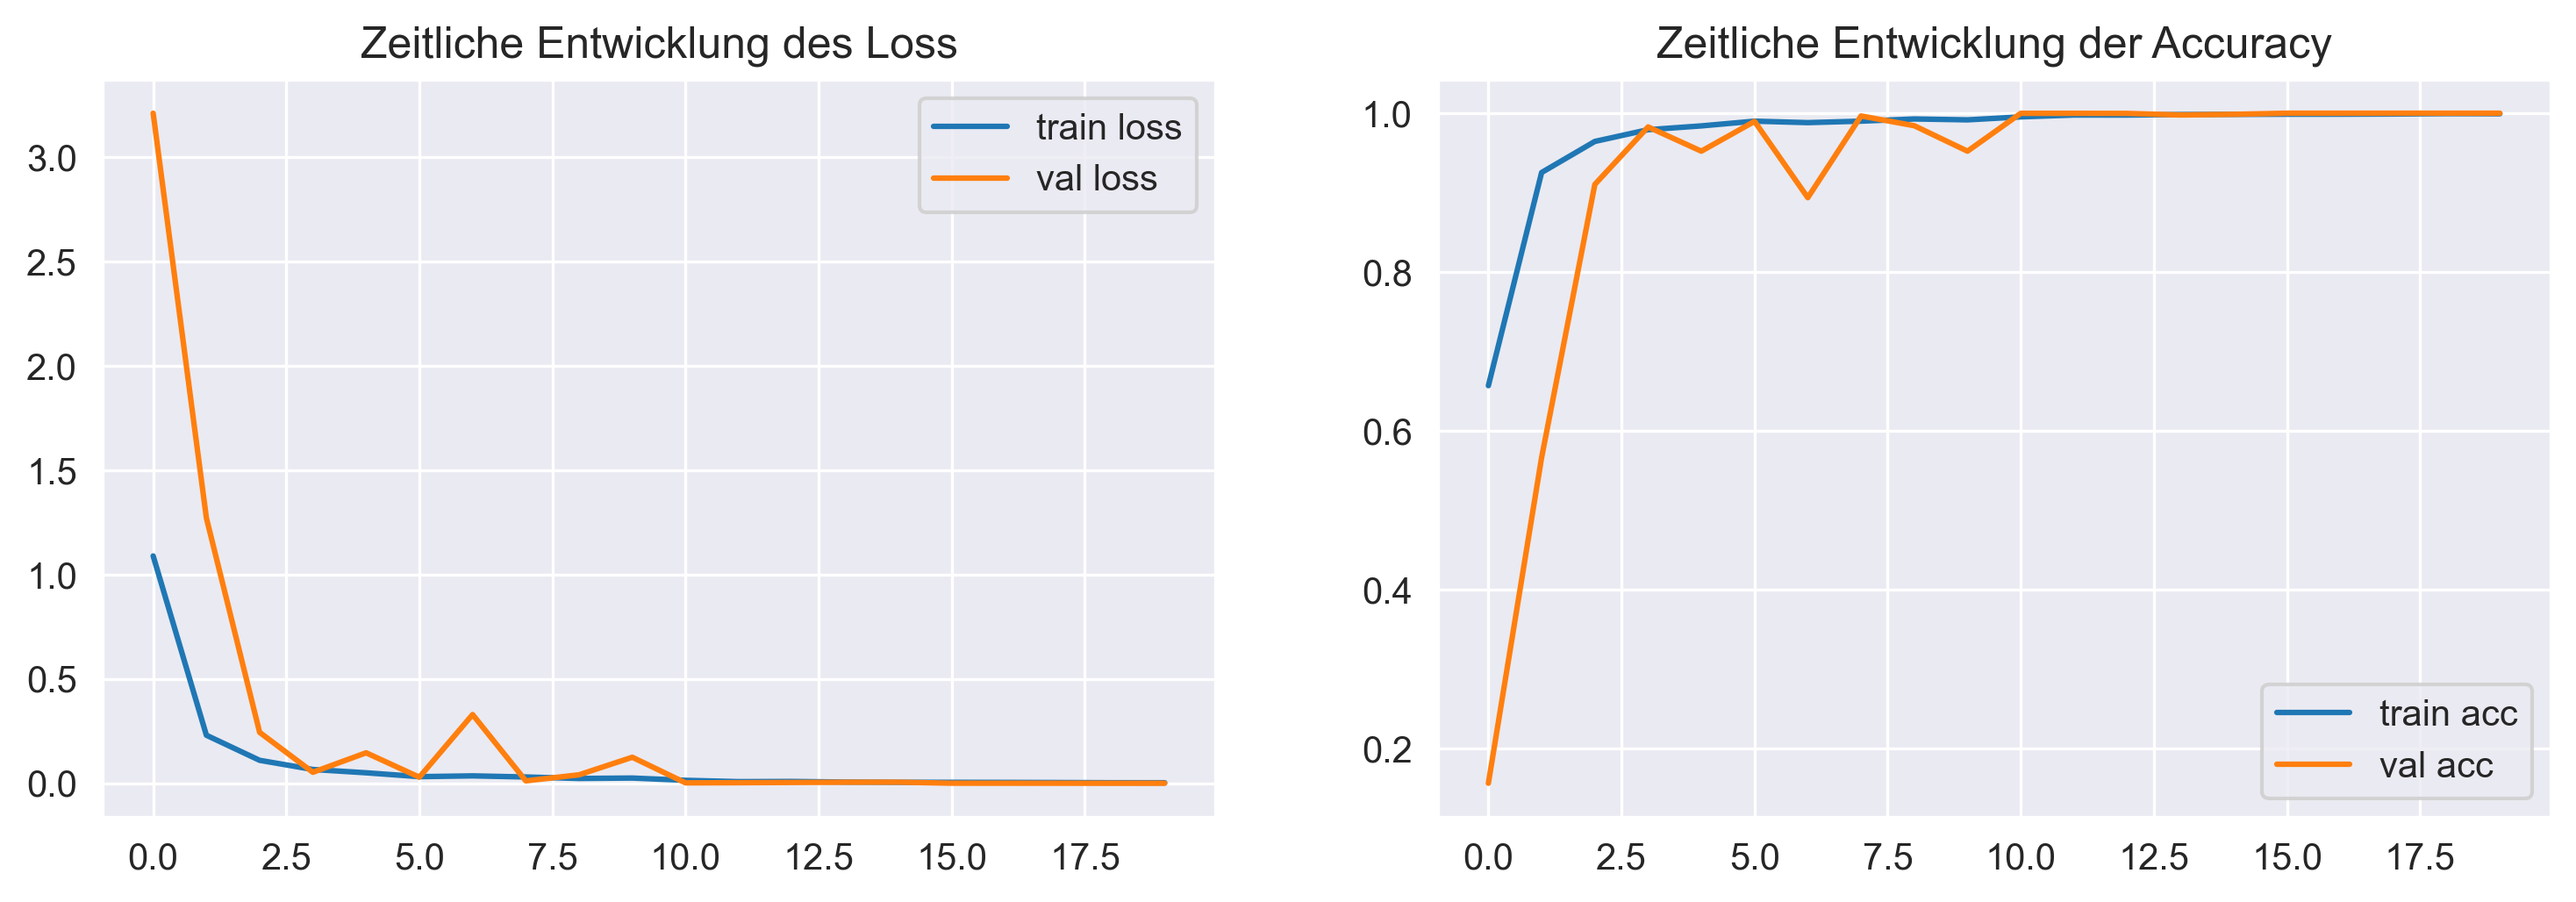

In [86]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.title("Zeitliche Entwicklung des Loss")

plt.subplot(2, 2, 2)

plt.plot(history['accuracy'], label='train acc')
plt.plot(history['val_accuracy'], label='val acc')

plt.legend()
plt.title("Zeitliche Entwicklung der Accuracy")

In [87]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"{'=' * 10} Evaluation of the Test Data {'=' * 10}")
print(f"n Training Samples: \t{train_num_samples}\nn Test Samples:\t\t\t{test_num_samples}")
print(f"Loss: \t\t\t\t\t{loss:.5f}\nAccuracy:\t\t\t\t{acc:.5f}")
print(f"{'=' * 10} Evaluation of the Test Data {'=' * 10}")

========== Evaluation of the Test Data ==========
n Training Samples: 	27455
n Test Samples:			7172
Loss: 					0.00032
Accuracy:				1.00000
========== Evaluation of the Test Data ==========


In [88]:
predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)

225/225 [==============================] - 2s 8ms/step


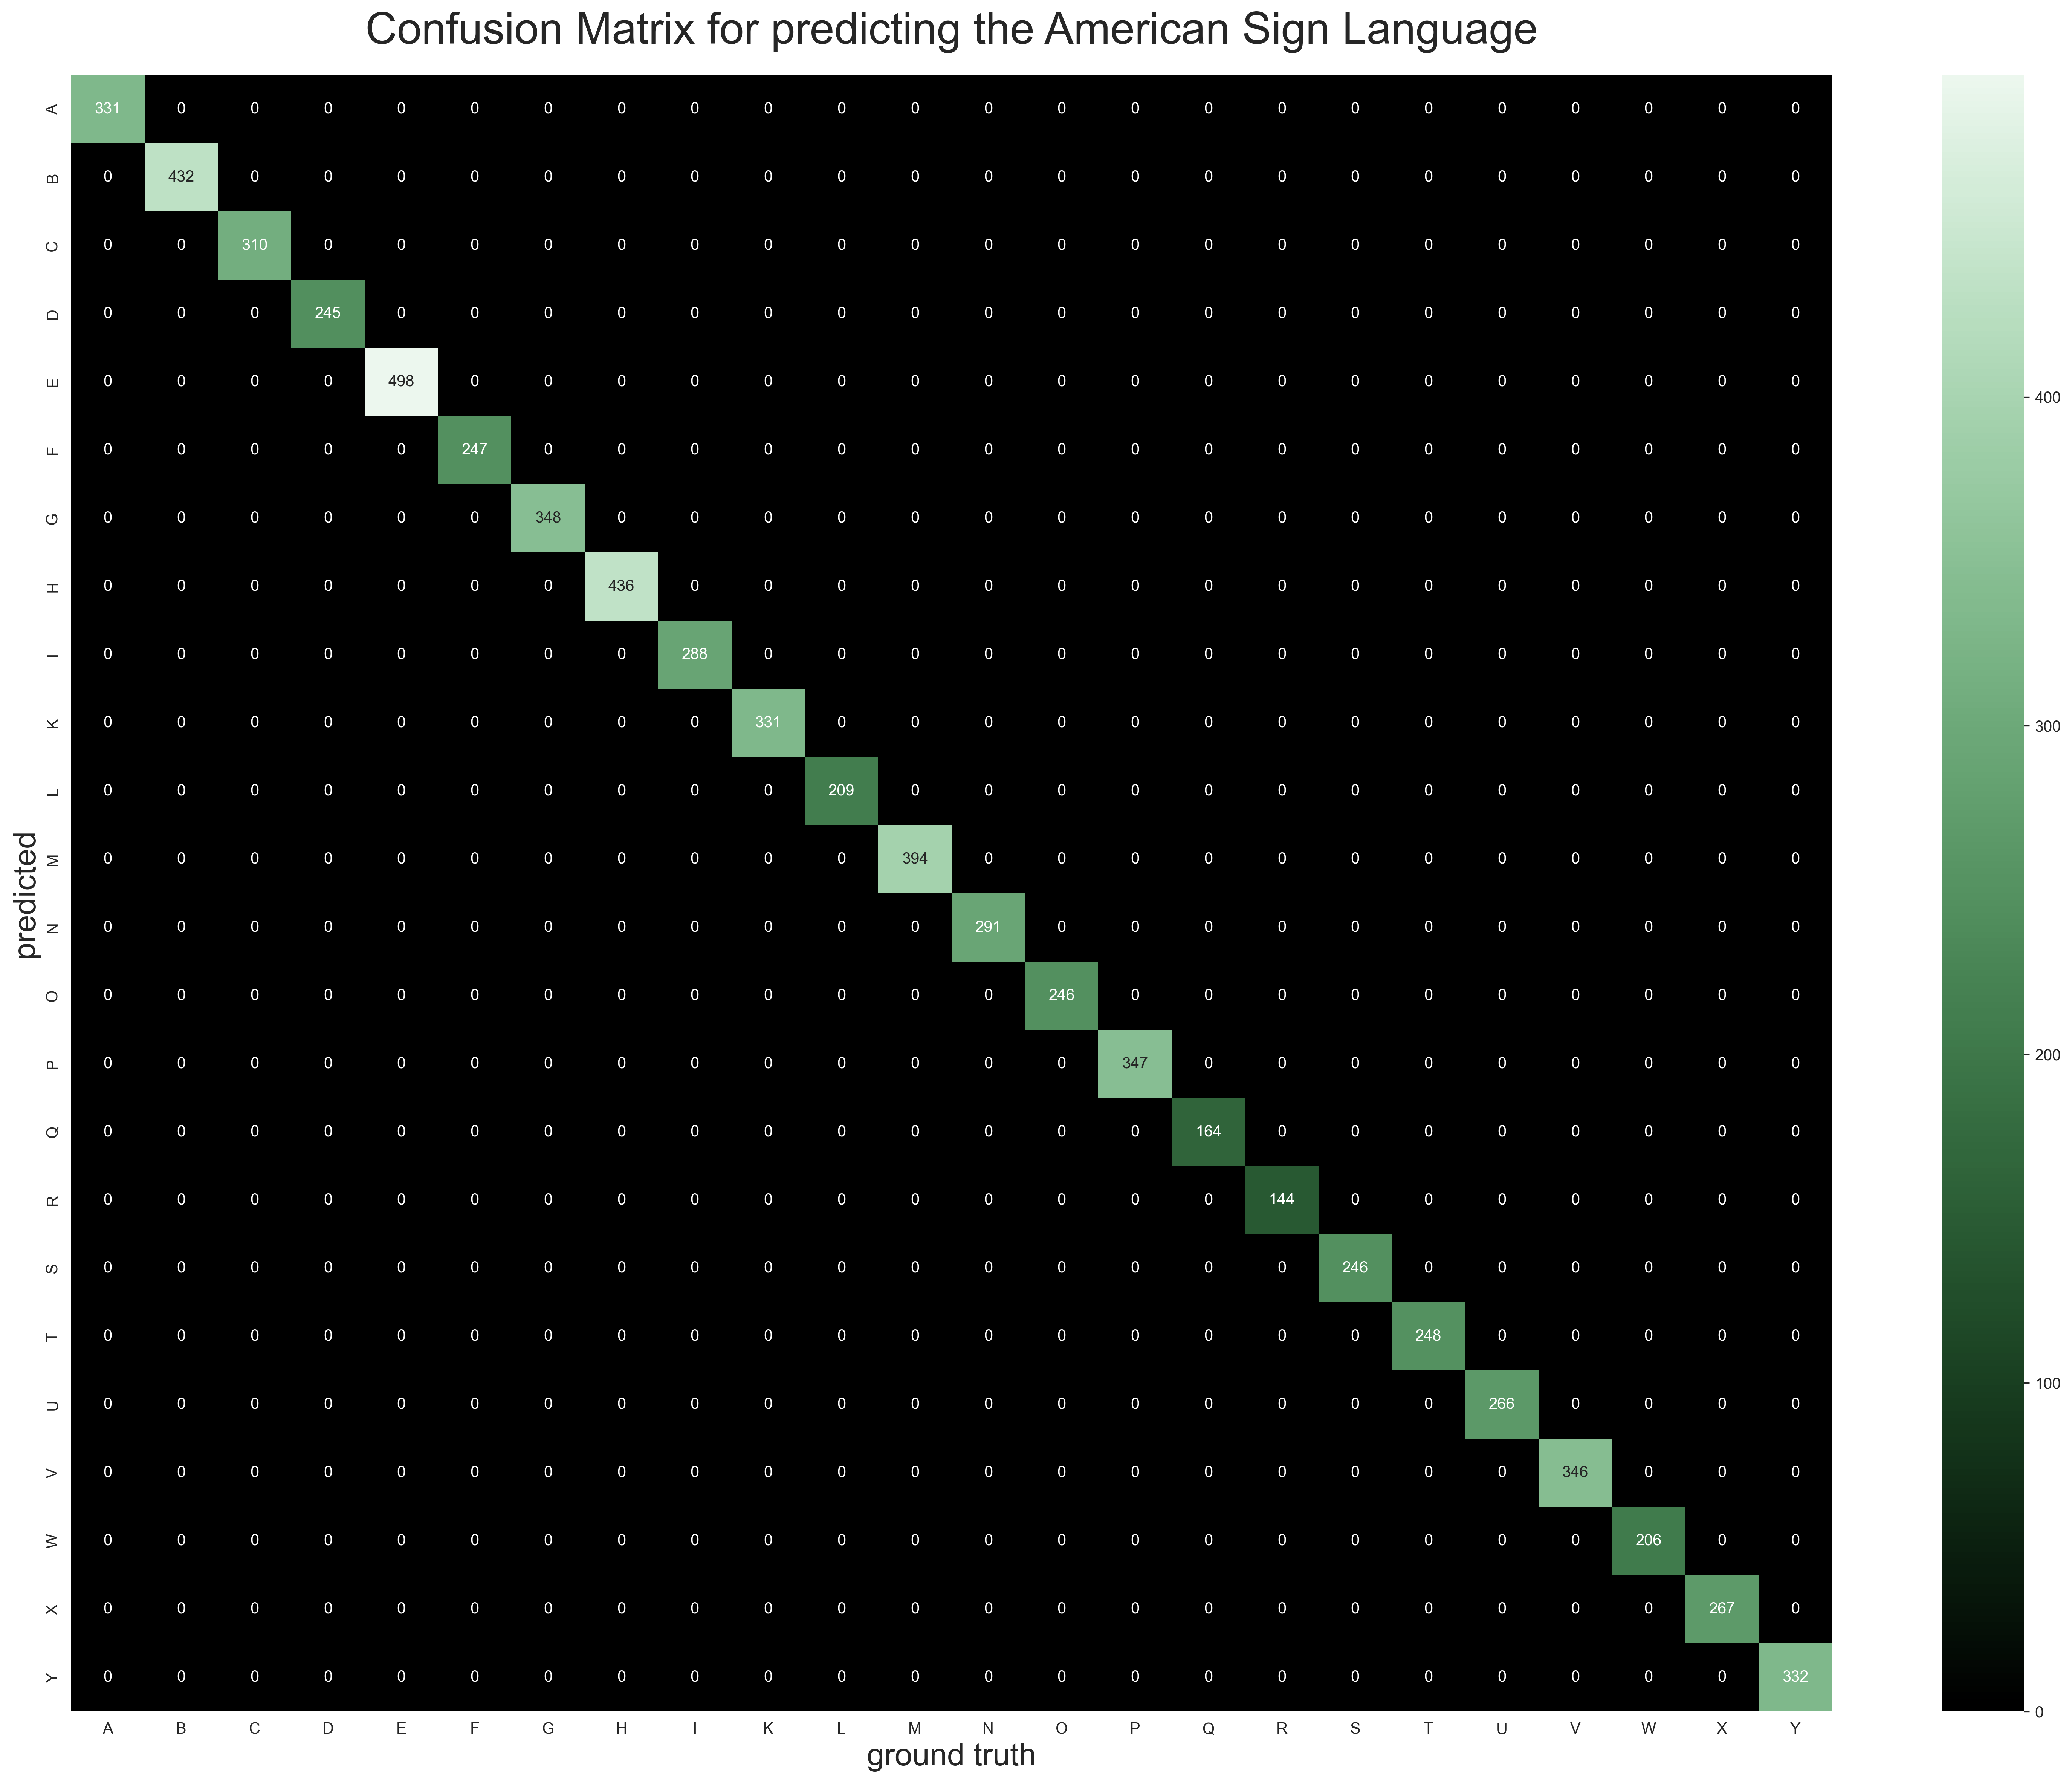

In [99]:
cmap = sns.diverging_palette(20, 220, as_cmap=True)
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

sns.heatmap(pd.DataFrame(confusion_matrix, index=classes, columns=classes), annot=True, cmap=cmap, fmt='d')
plt.tight_layout()
plt.title('Confusion Matrix for predicting the American Sign Language', fontsize=28, pad=20)
plt.ylabel('predicted', fontsize=20)
plt.xlabel('ground truth', fontsize=20)
plt.show()

In [90]:
amount_of_samples = 48


random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(x_test)), amount_of_samples)
sample_images = [x_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)

2/2 [==============================] - 0s 7ms/step


In [91]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(20, amount_of_samples +10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(amount_of_samples, 4,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(30, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction),
                 fontsize=12, color=color)
        plt.imshow(images[i])


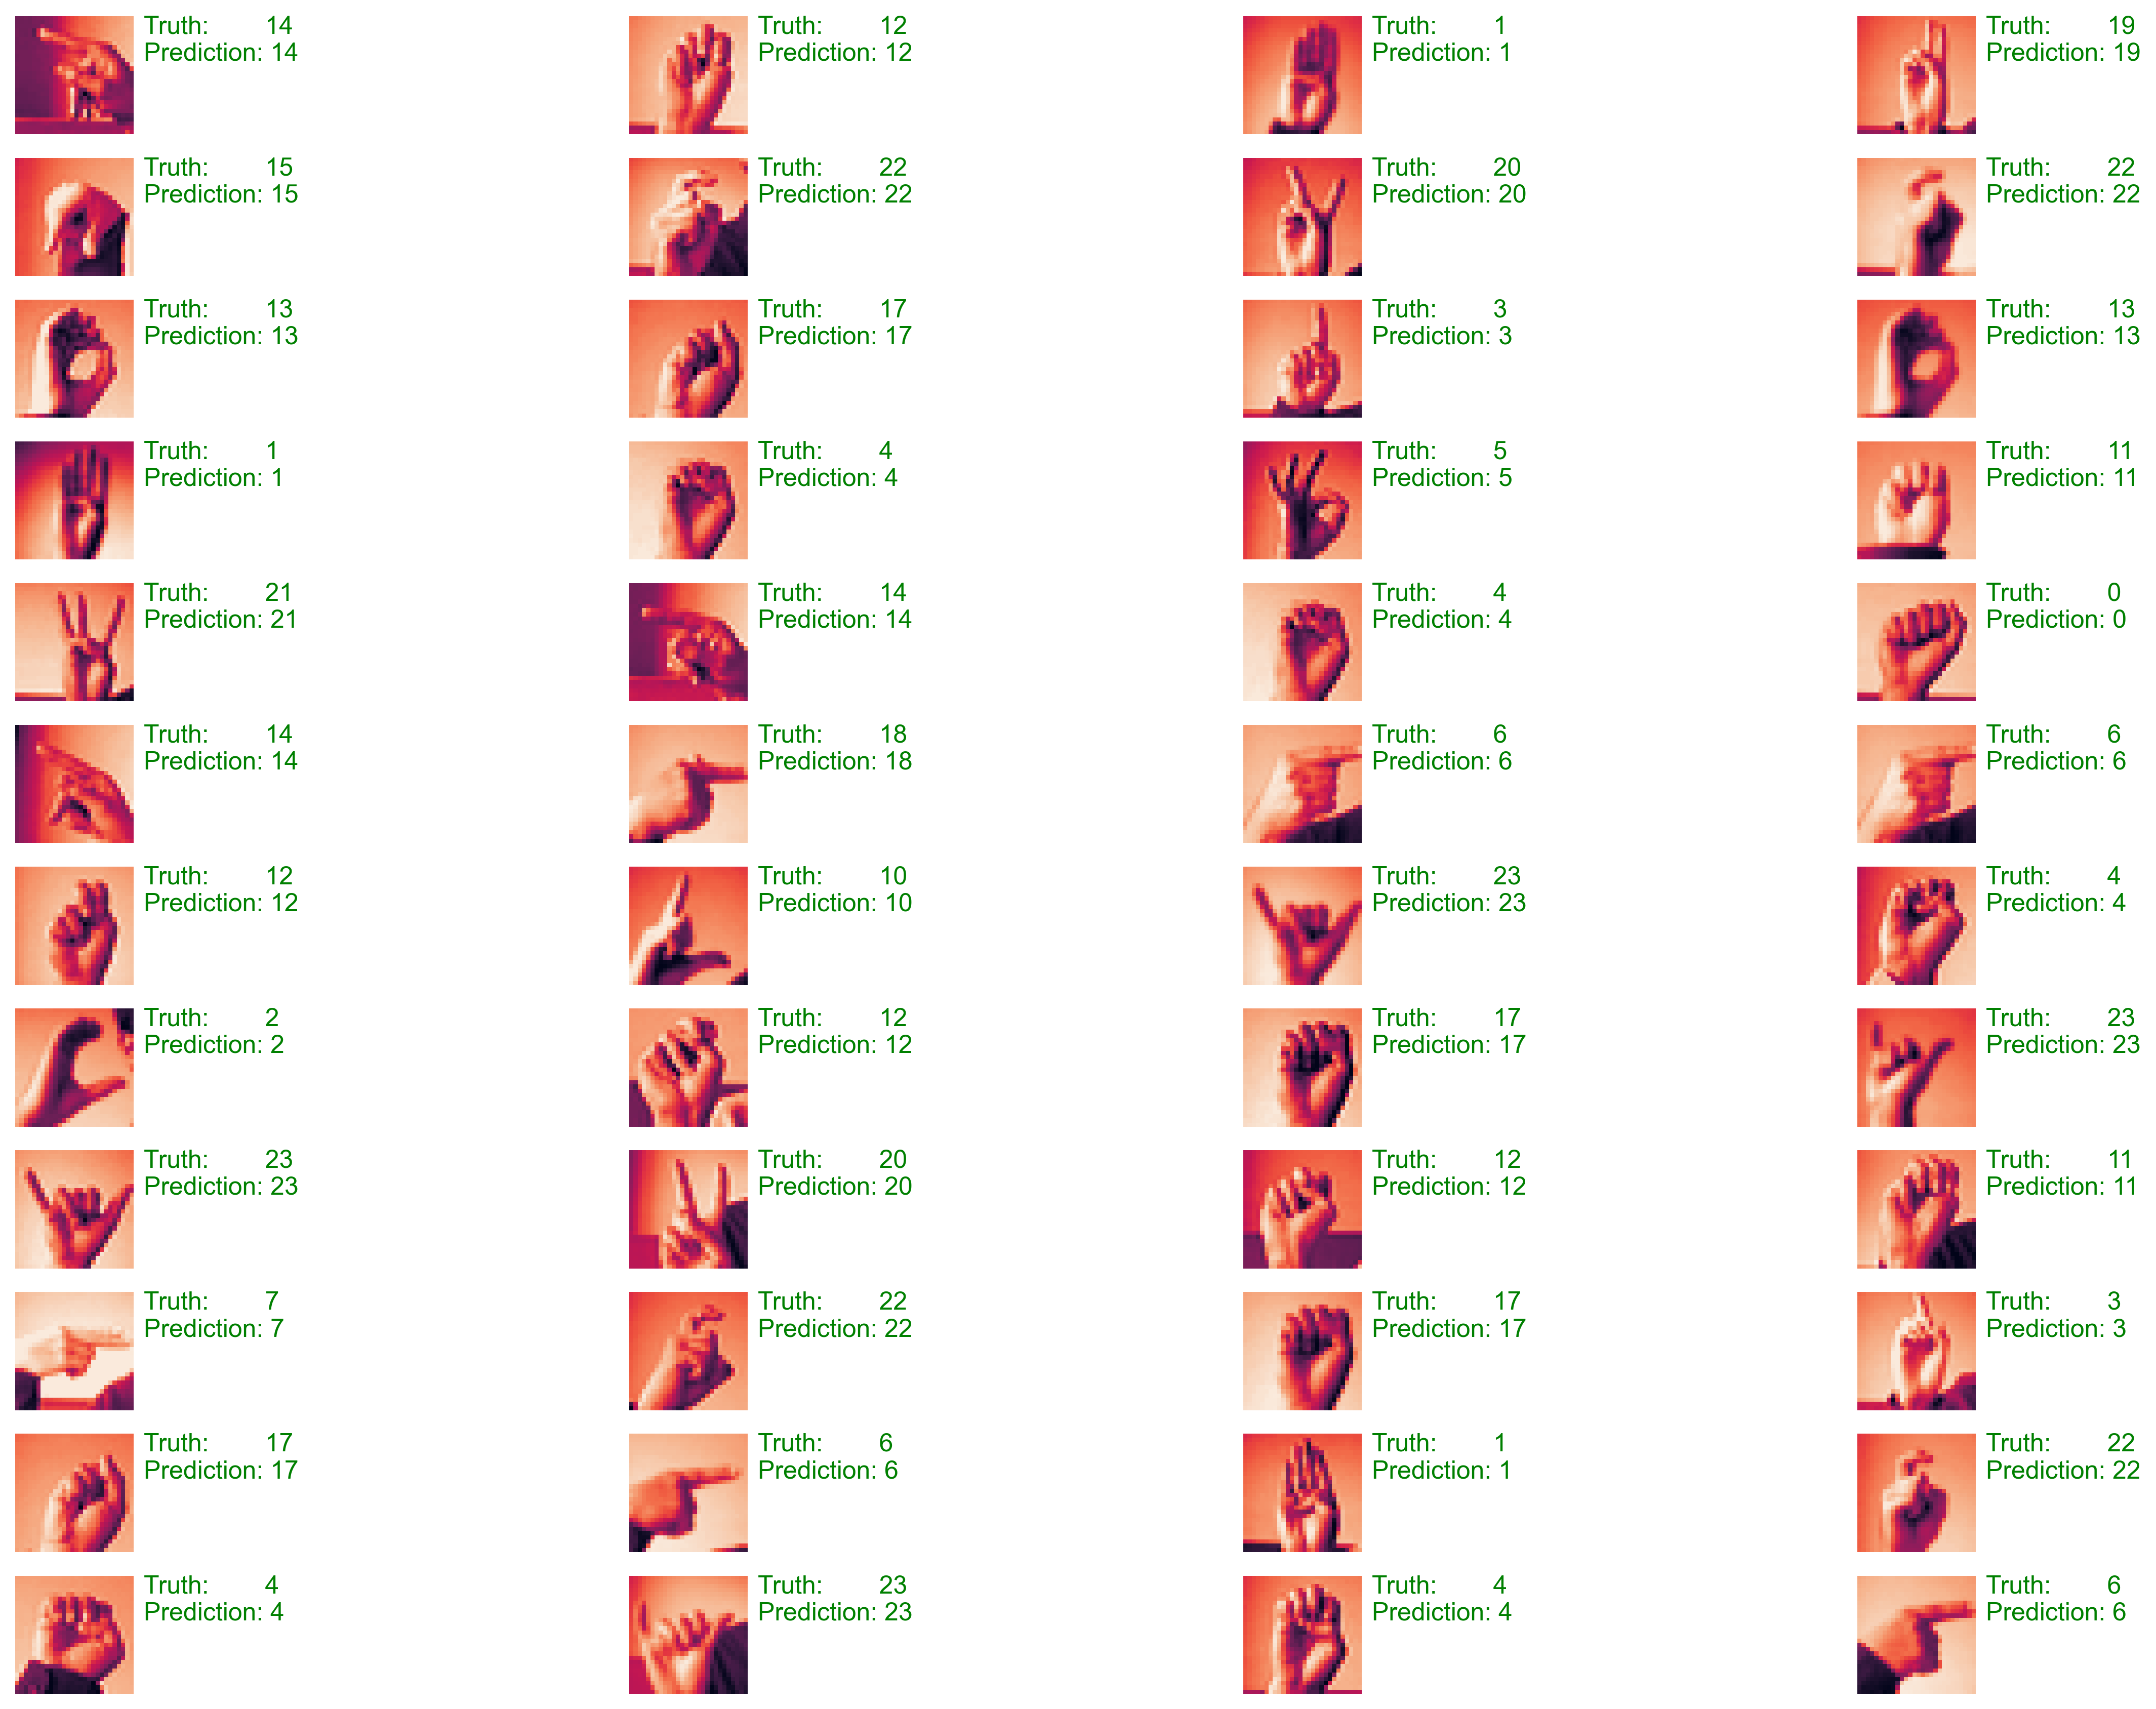

In [92]:
display_prediction(sample_images, ground_truth, predicted_categories)

In [93]:
ground_truth, predicted_categories

(array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13,  1,  4,  5, 11, 21,
        14,  4,  0, 14, 18,  6,  6, 12, 10, 23,  4,  2, 12, 17, 23, 23, 20,
        12, 11,  7, 22, 17,  3, 17,  6,  1, 22,  4, 23,  4,  6]),
 array([14, 12,  1, 19, 15, 22, 20, 22, 13, 17,  3, 13,  1,  4,  5, 11, 21,
        14,  4,  0, 14, 18,  6,  6, 12, 10, 23,  4,  2, 12, 17, 23, 23, 20,
        12, 11,  7, 22, 17,  3, 17,  6,  1, 22,  4, 23,  4,  6]))